In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import seaborn as sns
sns.set_theme()

In [2]:
import os
#add .. to path via os
os.chdir('..')
print(os.getcwd())

c:\Polimi\Master\2Sem\NLP-Project


In [3]:
from nlpChess.models.lit_modules import SeqAnnotator
from nlpChess.dataset.ChessDataset import ChessDataset

In [36]:
WEIGHT_LOCATION = "./checkpoints/lstm-best-v3.ckpt"
# WEIGHT_LOCATION = "/home/airlab/Documents/NLP-Project/checkpoints/result_seqs/lstm-best-v3.ckpt"

# Load the model
model = SeqAnnotator.load_from_checkpoint(WEIGHT_LOCATION)
model.eval()

SeqAnnotator(
  (embedding): Embedding(1968, 100)
  (rnn): LSTM(100, 512, batch_first=True, bidirectional=True)
  (fc_out): Sequential(
    (0): Linear(in_features=1024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
    (3): Softmax(dim=-1)
  )
  (loss_fn): CrossEntropyLoss()
  (reg_loss_fn): MSELoss()
)

In [39]:
from huggingface_hub import hf_hub_download

# Define model repository and filename
model_name = "ruhrpott/LSTM-chess-result-2-512-unidir"
filename = "model.safetensors"

# Download the checkpoint file
checkpoint_path = hf_hub_download(repo_id=model_name, filename=filename)
print(f"Checkpoint downloaded to: {checkpoint_path}")

model.safetensors:   0%|          | 0.00/15.3M [00:00<?, ?B/s]

Checkpoint downloaded to: C:\Users\Paolo\.cache\huggingface\hub\models--ruhrpott--LSTM-chess-result-2-512-unidir\snapshots\0c56bfa7e91e86abb520c66e0f207fca36360320\model.safetensors


In [40]:
from safetensors.torch import load_file

# Load the checkpoint state_dict
state_dict = load_file(checkpoint_path)

In [46]:
# Define your custom model
model = SeqAnnotator(
    n_target_classes=3,  # Set this according to the number of target classes
    label="result_seqs",  # Update as needed
    vocab_size=1968,  # Adjust based on your use case
    d_model=512,  # Should match the training config
    n_layers=2,
    model_type="lstm",
    bidirectional=False,
    word2vec = './model_weights/word2vec.model'
)

# Load the weights into the model
model.load_state_dict(state_dict)
model.eval()

SeqAnnotator(
  (embedding): Embedding(1968, 100)
  (rnn): LSTM(100, 512, num_layers=2, batch_first=True)
  (fc_out): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
    (3): Softmax(dim=-1)
  )
  (loss_fn): CrossEntropyLoss()
  (reg_loss_fn): MSELoss()
)

In [47]:
#Load the dataset
dataset = ChessDataset(
    parquette_path="./data/games_0001/train_100K.parquet",
    inputColumns=["Moves"],
    labelColumns=["checks", "Result", "Termination"]
)

Loading parquet file @  ./data/games_0001/train_100K.parquet  with columns  ['Moves', 'checks', 'Result', 'Termination']
Loaded 70000 rows and 4 columns


Converting columns to indices: 100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


In [48]:
dataset[0][0][0]

tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  23,  39,  40,  41,
         42,  26,  43,  44,  45,  46,  47,  28,  48,  49,  50,  51,  52,  53,
         54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
         68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  47,  79,  80,
         81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,
         95,  96,  97,  70,  98,  99, 100, 101, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114,  65, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125,  38, 126, 127, 128, 109, 129, 130, 131, 132,
        133, 134, 135, 136, 137, 138,  60, 139, 140, 141, 142, 143, 144, 145,
        100, 146, 147, 148, 149, 150, 151, 152, 153])

In [49]:
tensors = []
for i in tqdm.tqdm(range(10000)):
    # Convert the data to a tensor
    d = dataset[i][0][0].unsqueeze(0)
    tensors.append(d)

100%|██████████| 10000/10000 [00:05<00:00, 1848.84it/s]


In [53]:
import pickle
GET_EMBEDDINGS = True

if GET_EMBEDDINGS:
    outcomes = []
    hs = []
    cs = []

    for d in tqdm.tqdm(tensors):
        # Move the tensor to the same device as the model
        d = d.to(model.device)

        # Get the model output
        with torch.no_grad():
            output, (h, c) = model(d)

        # Get the last hidden state
        outcomes.append(output.cpu().numpy())
        hs.append(h.cpu().numpy())
        cs.append(c.cpu().numpy())

    #Save the embeddings
    with open('embeddings.pkl', 'wb') as f:
        pickle.dump({'outcomes': outcomes, 'hs': hs, 'cs': cs}, f)

100%|██████████| 10000/10000 [04:24<00:00, 37.84it/s]


In [74]:
#Load the embeddings
with open('embeddings.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [75]:
data = np.array([d for d in tqdm.tqdm(dataset)], dtype=object)

100%|██████████| 70000/70000 [00:40<00:00, 1735.05it/s]


In [76]:
data_sampled = data[:10000]

In [ ]:
cs = torch.Tensor(embeddings['cs']).squeeze()
cs.shape

torch.Size([10000, 2, 1, 512])

In [78]:
cs.shape

torch.Size([10000, 2, 512])

In [ ]:
cs_sampled_foreward = cs[:, 0, :]
cs_sampled_foreward.shape

torch.Size([10000, 512])

In [102]:
cs[0][1][1]

tensor(0.2518)

In [103]:
matchOutcomes = [d[1][1] for d in tqdm.tqdm(data_sampled)]
matchOutcomes = np.array(matchOutcomes, dtype=int)
matchOutcomes.shape

100%|██████████| 10000/10000 [00:00<00:00, 1110926.76it/s]


(10000,)

In [104]:
dataset.lookup_tables.keys()

dict_keys(['Moves', 'checks', 'Result', 'Termination'])

In [105]:
import yaml
#load a yaml file with the match outcomes
with open('./data/games_0001/result_seqs_lookup_table.yaml', 'r') as f:
    match_outcomes_lookup = yaml.safe_load(f)['result_seqs']

match_outcomes_lookup = {v: k for k, v in match_outcomes_lookup.items()}
match_outcomes_lookup

{2: '0-1', 1: '1-0', 3: '1/2-1/2'}

In [106]:
matchOutcomesLabels = [match_outcomes_lookup[d] for d in tqdm.tqdm(matchOutcomes)]
matchOutcomesLabels = np.array(matchOutcomesLabels)
matchOutcomesLabels

100%|██████████| 10000/10000 [00:00<00:00, 2497204.10it/s]


array(['1-0', '0-1', '1/2-1/2', ..., '1/2-1/2', '1-0', '1/2-1/2'],
      dtype='<U7')

In [107]:
matchTerminations = [d[1][2] for d in tqdm.tqdm(data_sampled)]

100%|██████████| 10000/10000 [00:00<00:00, 1111073.91it/s]


In [108]:
matchTerminationLookup = dataset.lookup_tables['Termination']
matchTerminationLookup = {v: k for k, v in matchTerminationLookup.items()}
matchTerminationLookup

{1: 'CHECKMATE',
 2: 'INSUFFICIENT_MATERIAL',
 3: 'SEVENTYFIVE_MOVES',
 4: 'FIVEFOLD_REPETITION',
 5: 'STALEMATE'}

In [109]:
matchTerminationsLabels = [matchTerminationLookup[int(d)] for d in tqdm.tqdm(matchTerminations)]
matchTerminationsLabels = np.array(matchTerminationsLabels)
matchTerminationsLabels

100%|██████████| 10000/10000 [00:00<00:00, 588195.43it/s]


array(['CHECKMATE', 'CHECKMATE', 'INSUFFICIENT_MATERIAL', ...,
       'FIVEFOLD_REPETITION', 'CHECKMATE', 'STALEMATE'], dtype='<U21')

In [110]:
from matplotlib.lines import Line2D

matchTerminationColorsPalette = {
    'CHECKMATE': 'red',
    'INSUFFICIENT_MATERIAL': 'blue',
    'SEVENTYFIVE_MOVES': 'green',
    'FIVEFOLD_REPETITION': 'purple',
    'STALEMATE': 'orange'
}
legendElementTermination = [
    plt.Line2D([0], [0], marker='o', color='w', label=key, 
               markerfacecolor=value, markersize=10) 
    for key, value in matchTerminationColorsPalette.items()
]

matchTerminationColors = [matchTerminationColorsPalette[d] for d in tqdm.tqdm(matchTerminationsLabels)]
matchTerminationColors = np.array(matchTerminationColors)
matchTerminationColors

100%|██████████| 10000/10000 [00:00<00:00, 1428383.05it/s]


array(['red', 'red', 'blue', ..., 'purple', 'red', 'orange'], dtype='<U6')

In [111]:
# Use a nicer color palette from seaborn
palette = sns.color_palette("Set1", n_colors=3)
labelColors = {
    '1-0': palette[0],
    '0-1': palette[1],
    '1/2-1/2': palette[2],
}

matchOutcomesColors = [labelColors[d] for d in tqdm.tqdm(matchOutcomesLabels)]
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8)
    for label, color in labelColors.items()
]
matchOutcomesColors

100%|██████████| 10000/10000 [00:00<00:00, 1111338.86it/s]


[(0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.30196078431372547, 0.6862745098039216, 0.2901960784313726),
 (0.8941176470588236, 0.10196078431372549, 0.10980392156862745),
 (0.21568627450980393, 0.49411764705882355, 0.7215686274509804),
 (0.30196078431372547, 0.686274

In [112]:
matchOutcomes

array([1, 2, 3, ..., 3, 1, 3])

In [113]:
from sklearn.decomposition import PCA
pca = PCA(n_components=200)
cs_sampled_pca = pca.fit_transform(cs_sampled_foreward)
cs_sampled_pca.shape

(10000, 200)

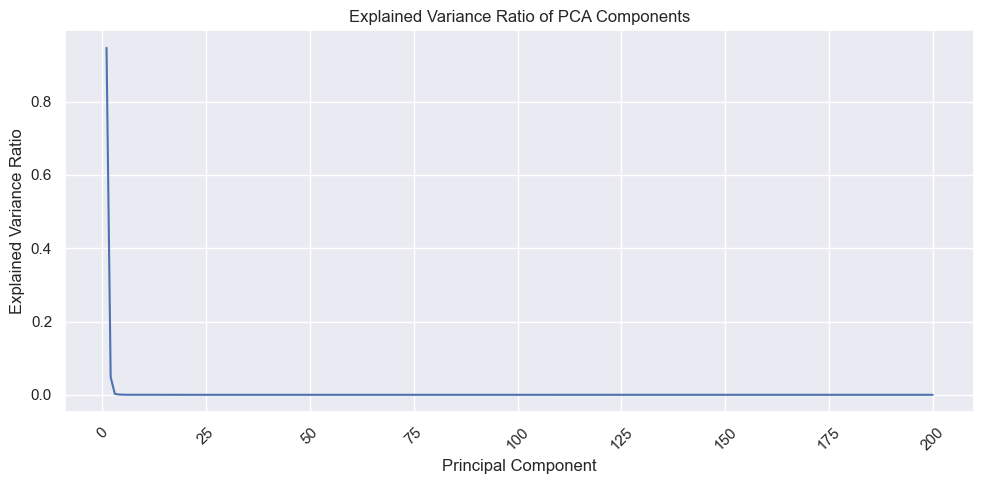

In [114]:
#Plot the explained variance ratio
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio of PCA Components')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

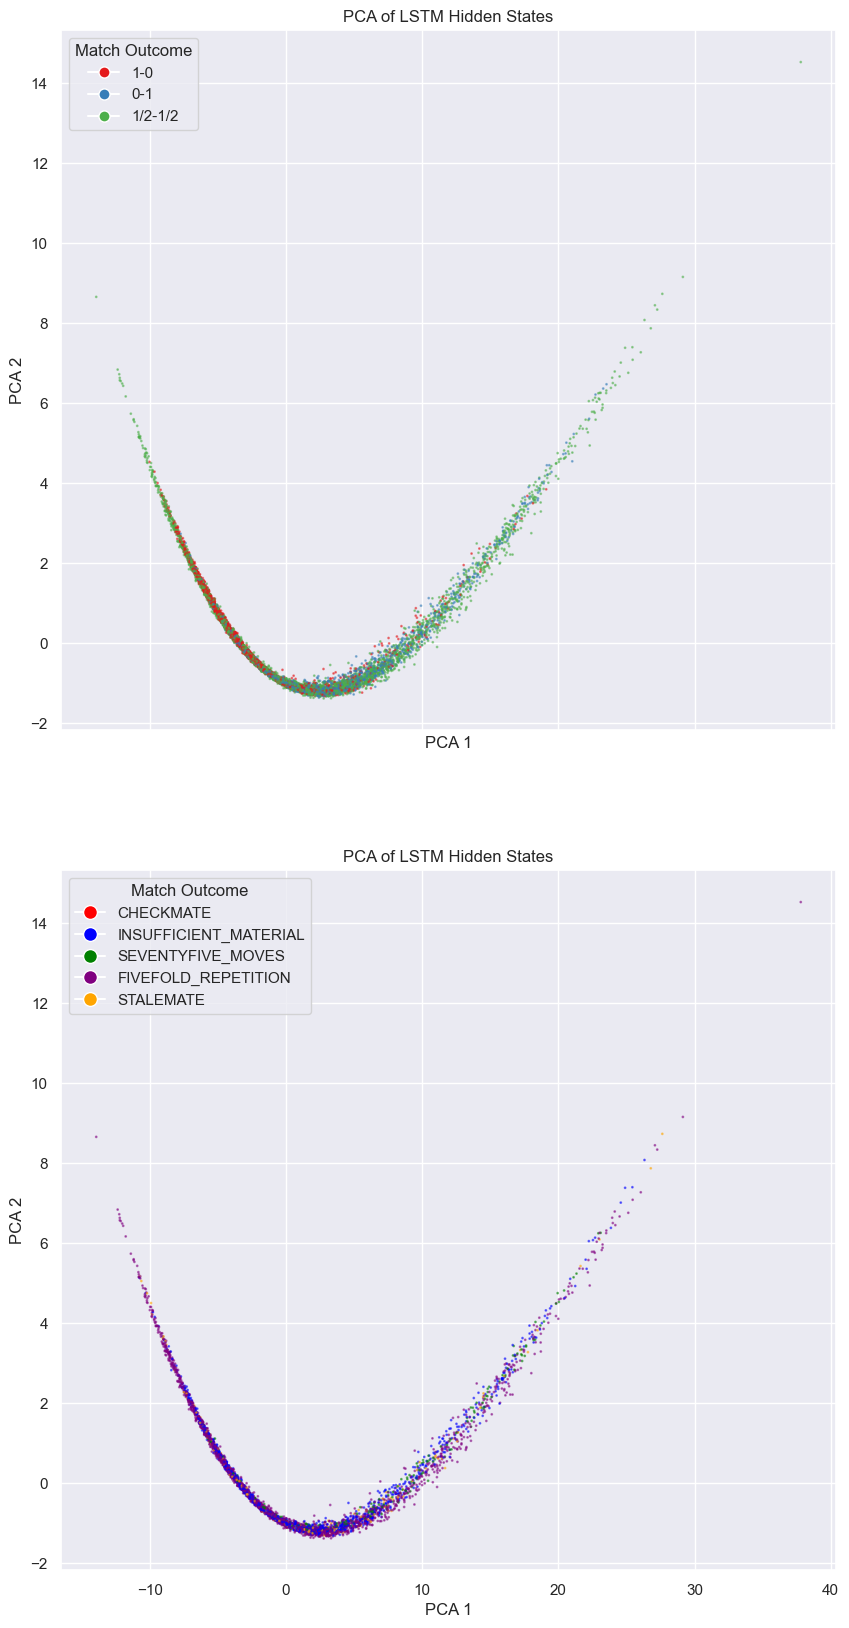

In [115]:
# Plot the PCA
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_pca[:, 0], cs_sampled_pca[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("PCA of LSTM Hidden States")
axes[0].set_xlabel("PCA 1")
axes[0].set_ylabel("PCA 2")

cs_sampled_noCkeckmates = cs_sampled_pca[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_noCkeckmates[:, 0], cs_sampled_noCkeckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Outcome")
axes[1].set_title("PCA of LSTM Hidden States")
axes[1].set_xlabel("PCA 1")
axes[1].set_ylabel("PCA 2")
plt.show()

In [116]:
#Perform tsne
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, perplexity=30, n_jobs=8, verbose=1, metric="cosine")
cs_sampled_tsne = tsne.fit_transform(cs_sampled_foreward)
cs_sampled_tsne.shape

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.011s...
[t-SNE] Computed neighbors for 10000 samples in 4.375s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.000432


KeyboardInterrupt: 

<Figure size 1000x1000 with 0 Axes>

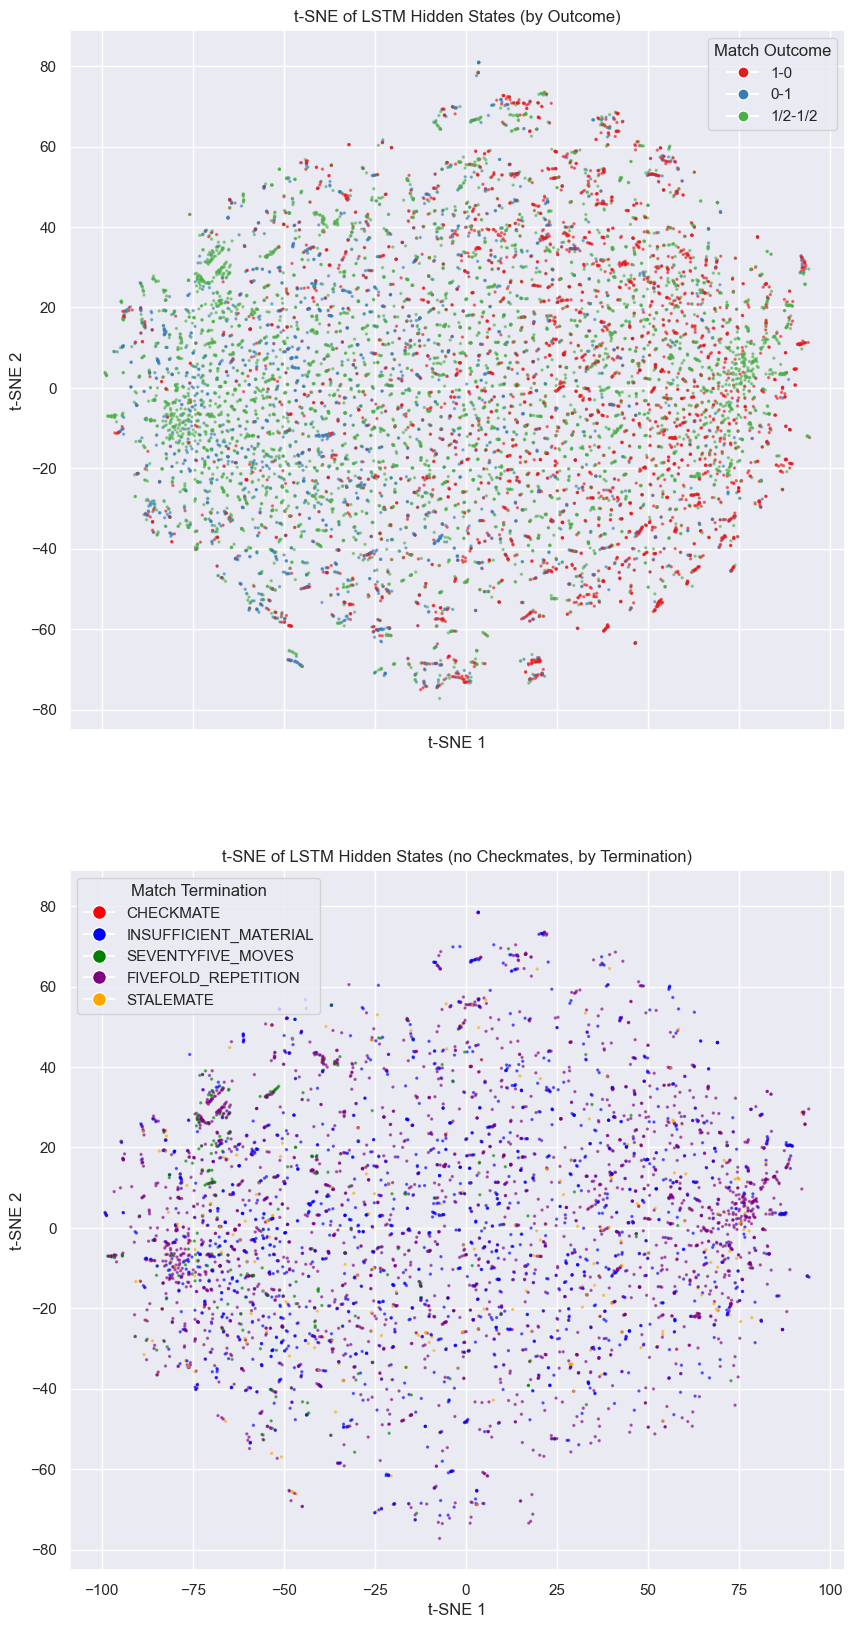

In [ ]:
# Plot the t-SNE
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_tsne[:, 0], cs_sampled_tsne[:, 1], alpha=0.5, s=2, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("t-SNE of LSTM Hidden States (by Outcome)")
axes[0].set_xlabel("t-SNE 1")
axes[0].set_ylabel("t-SNE 2")

cs_sampled_tsne_noCheckmates = cs_sampled_tsne[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_tsne_noCheckmates[:, 0], cs_sampled_tsne_noCheckmates[:, 1], alpha=0.5, s=2, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Termination")
axes[1].set_title("t-SNE of LSTM Hidden States (no Checkmates, by Termination)")
axes[1].set_xlabel("t-SNE 1")
axes[1].set_ylabel("t-SNE 2")
plt.show()

In [ ]:
#Perform umap
import umap
umap_model = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric='cosine', verbose=1)
cs_sampled_umap = umap_model.fit_transform(cs_sampled_foreward)
cs_sampled_umap.shape

c:\Polimi\Master\2Sem\NLP-Project\.conda\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(angular_rp_forest=True, metric='cosine', verbose=1)
Sun May 25 02:46:02 2025 Construct fuzzy simplicial set
Sun May 25 02:46:02 2025 Finding Nearest Neighbors
Sun May 25 02:46:02 2025 Building RP forest with 10 trees
Sun May 25 02:46:02 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	 6  /  13
	Stopping threshold met -- exiting after 6 iterations
Sun May 25 02:46:02 2025 Finished Nearest Neighbor Search
Sun May 25 02:46:03 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun May 25 02:46:07 2025 Finished embedding


(10000, 2)

<Figure size 1000x1000 with 0 Axes>

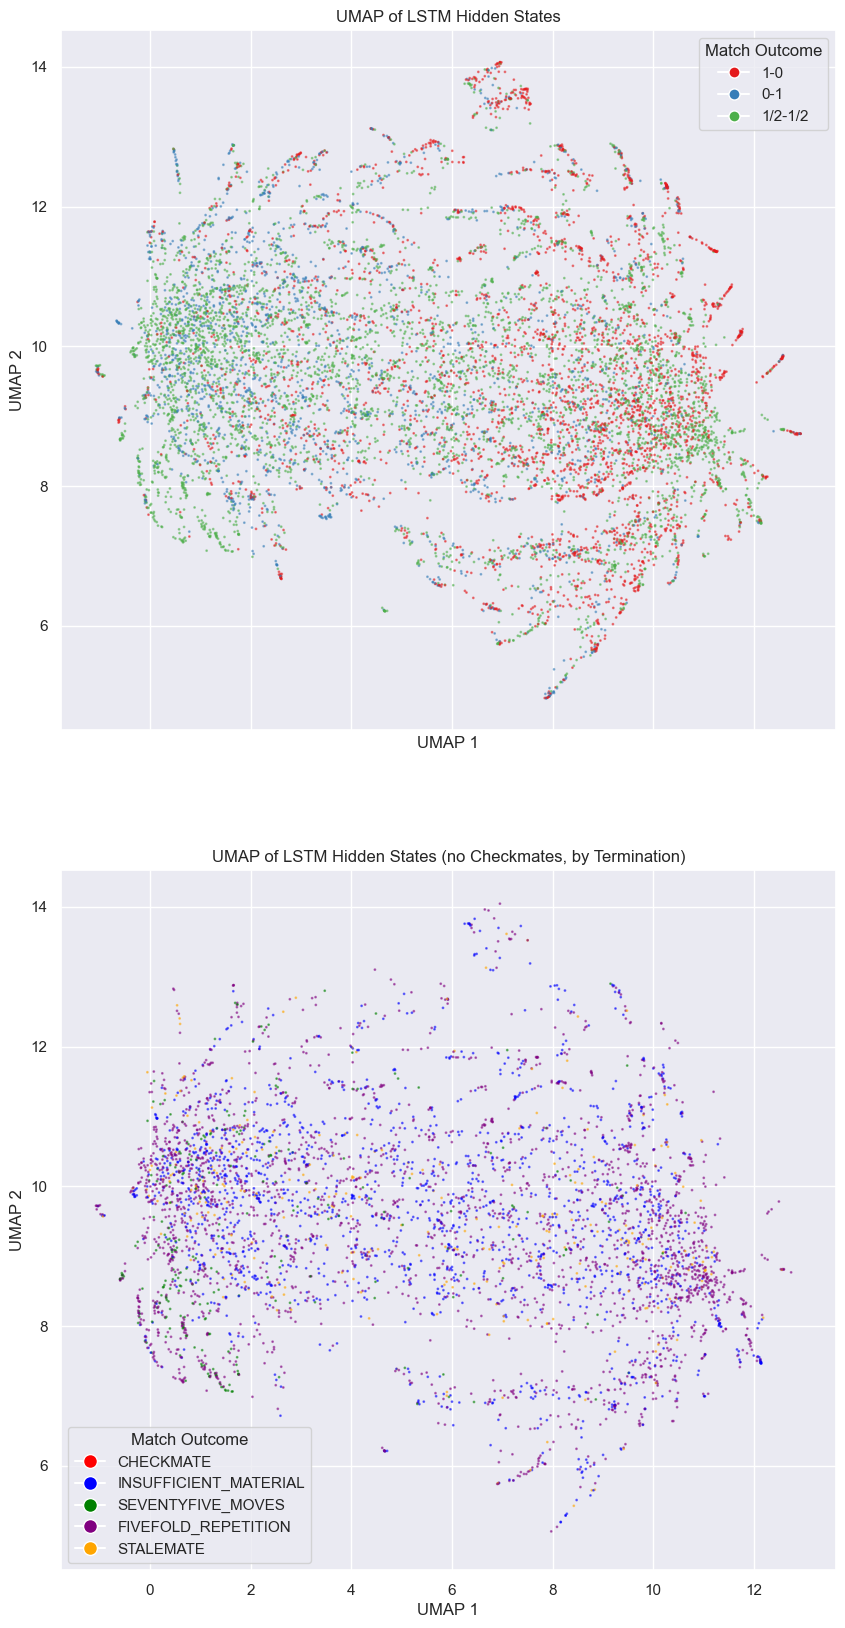

In [ ]:
# Plot the UMAP
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
axes[0].scatter(cs_sampled_umap[:, 0], cs_sampled_umap[:, 1], alpha=0.5, s=1, c=matchOutcomesColors)
axes[0].legend(handles=legend_elements, title="Match Outcome")
axes[0].set_title("UMAP of LSTM Hidden States")
axes[0].set_xlabel("UMAP 1")
axes[0].set_ylabel("UMAP 2")

cs_sampled_umap_noCheckmates = cs_sampled_umap[matchTerminationsLabels != 'CHECKMATE']
matchTerminationColors_noCheckmates = matchTerminationColors[matchTerminationsLabels != 'CHECKMATE']
axes[1].scatter(cs_sampled_umap_noCheckmates[:, 0], cs_sampled_umap_noCheckmates[:, 1], alpha=0.5, s=1, c=matchTerminationColors_noCheckmates)
axes[1].legend(handles=legendElementTermination, title="Match Outcome")
axes[1].set_title("UMAP of LSTM Hidden States (no Checkmates, by Termination)")
axes[1].set_xlabel("UMAP 1")
axes[1].set_ylabel("UMAP 2")
plt.show()


# RAG

In [ ]:
def topClosestTo(game, n=10):
    """
    Find the top n closest games to the given game based on the UMAP embedding.
    """
    # Move the tensor to the same device as the model
    fame = game.to(model.device)

    # Get the model output
    with torch.no_grad():
        output, (h, c) = model(game)

    # Get the last hidden state
    game_embedding = c.squeeze().cpu()
    cs_embeddings = cs_sampled_foreward
    # Compute distances in parallel using torch
    # Normalize embeddings for cosine distance
    game_embedding_norm = game_embedding[0] / game_embedding[0].norm()
    cs_embeddings_norm = cs_embeddings / cs_embeddings.norm(dim=1, keepdim=True)
    similarity = torch.matmul(cs_embeddings_norm, game_embedding_norm)
    closest_indices = torch.topk(similarity, n).indices.cpu().numpy()
    return closest_indices, similarity[closest_indices].cpu().numpy()

topClosestTo(dataset[0][0][0])

(array([   0, 4383, 9067, 5999, 8844, 9997, 4147, 8312, 9711, 2254],
       dtype=int64),
 array([0.99999994, 0.9731257 , 0.9726935 , 0.9726355 , 0.97180915,
        0.969946  , 0.9695353 , 0.9693592 , 0.9686277 , 0.9686277 ],
       dtype=float32))

Game 1
	Similarity: 0.9999999403953552
	Length: 163 moves
	Outcome: 1-0
--------------------------------------------------
Game 2
	Similarity: 0.973125696182251
	Length: 161 moves
	Outcome: 1-0
--------------------------------------------------
Game 3
	Similarity: 0.9726935029029846
	Length: 200 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 4
	Similarity: 0.9726355075836182
	Length: 351 moves
	Outcome: 1-0
--------------------------------------------------
Game 5
	Similarity: 0.9718091487884521
	Length: 89 moves
	Outcome: 1-0
--------------------------------------------------
Game 6
	Similarity: 0.969946026802063
	Length: 93 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 7
	Similarity: 0.9695352911949158
	Length: 147 moves
	Outcome: 1-0
--------------------------------------------------
Game 8
	Similarity: 0.9693592190742493
	Length: 364 moves
	Outcome: 1/2-1/2
--------------------------------------------------
Game 9
	

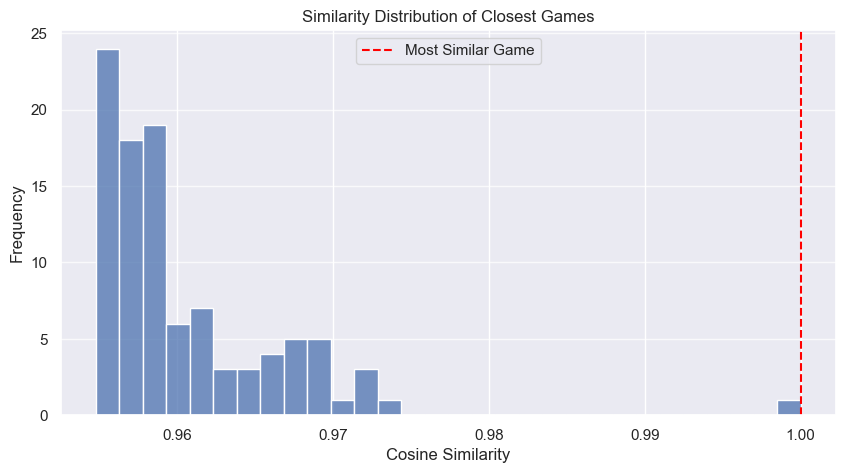

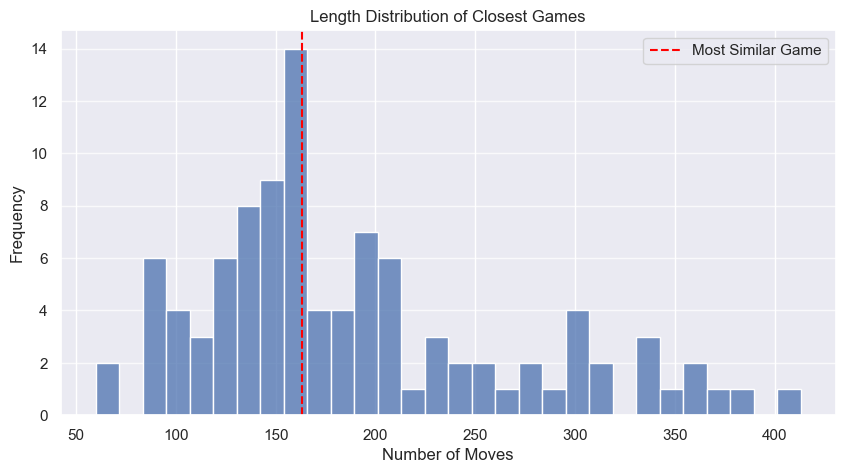

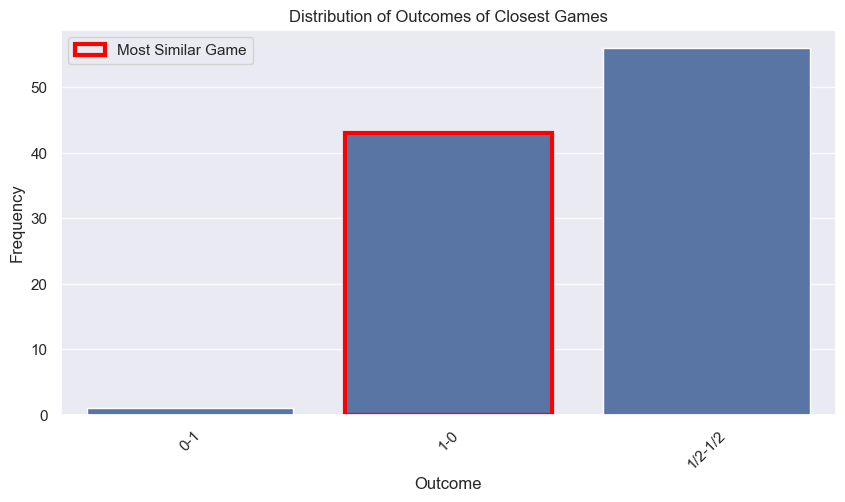

In [ ]:
from matplotlib.patches import Patch

closest_indices, similarity = topClosestTo(dataset[0][0][0], n=100)

closest_games = [dataset[i][0][0] for i in closest_indices]
lengths = [len(game) for game in closest_games]
similarityOutcomes = matchOutcomesLabels[closest_indices]
for i, game in enumerate(closest_games):
    print(f"Game {i+1}")
    print(f"\tSimilarity: {similarity[i]}")
    print(f"\tLength: {len(game)} moves")
    print(f"\tOutcome: {similarityOutcomes[i]}")
    print("-" * 50)

# Plot the similarity distribution and mark the most similar game
plt.figure(figsize=(10, 5))
sns.histplot(similarity, bins=30)
plt.axvline(similarity[0], color='red', linestyle='--', label='Most Similar Game')
plt.title("Similarity Distribution of Closest Games")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Plot the length distribution of the closest games and mark the most similar game
plt.figure(figsize=(10, 5))
sns.histplot(lengths, bins=30)
plt.axvline(lengths[0], color='red', linestyle='--', label='Most Similar Game')
plt.title("Length Distribution of Closest Games")
plt.xlabel("Number of Moves")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

# Plot the distribution of outcomes of the closest games and mark the most similar game
plt.figure(figsize=(10, 5))
ax = sns.countplot(x=similarityOutcomes, order=np.unique(similarityOutcomes))
# Mark the outcome of the most similar game
most_similar_outcome = similarityOutcomes[0]
unique_outcomes = np.unique(similarityOutcomes)
most_similar_idx = np.where(unique_outcomes == most_similar_outcome)[0][0]
for i, p in enumerate(ax.patches):
    if i == most_similar_idx:
        p.set_edgecolor('red')
        p.set_linewidth(3)
# Add legend for the most similar game
legend_elements = [Patch(facecolor='none', edgecolor='red', linewidth=3, label='Most Similar Game')]
plt.title("Distribution of Outcomes of Closest Games")
plt.xlabel("Outcome")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.75)
plt.legend(handles=legend_elements)
plt.show()